<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Topic Modeling and Latent Dirichlet Allocation (LDA)

_Authors: Dave Yerrington (SF)_

---

### Learning Objectives
- Discover how search engines benefit from topic modeling.
- Visualize a simple example of term vectors.
- Walk through the coding of a simplified LDA topic model.
- Gain an intuition for what LDA is doing.
- Understand the pros and cons of LDA topic modeling.

In [7]:
import numpy as np
names = [
    'Wei Chiat',
    'Evan',
    'Chun Wai',
    'Chee Keet',
    'Jingyun',
    'Wilson',
    'Yongxun',
    'Elsia',
    'Serene',
    'Shruthi',
    'William',
    'Adrian',
    'Alvin Tham',
    'Yuan Liang',
    'Yu Fung',
    'Su Ying',
    'Jordan',
    'Kristin',
    'Wei Ling',
    'Zi Liang',
]
def groupMaker(itemlist, size, seed=None):
    """
    Splits a list into random groups of n size.
    
    Parameters
    __________
    
    itemlist : list
        This list contains the list of items to be grouped.
               
    size : int
        The number of items in a group
        
    seed : int
        Seeds the generator with np.random.seed().
    
    
    Returns
    __________
    
    groups : list of lists
        Outputs a list which includes all the random groups in it as lists
    
    """
    
    np.random.seed(seed)
    items = list(itemlist)
    np.random.shuffle(items)
    
    return [items[i: i + size] for i in range(0, len(items), size)]
groupMaker(names, 4, seed=90)

[['Alvin Tham', 'Kristin', 'Yongxun', 'Jordan'],
 ['Shruthi', 'Evan', 'Serene', 'Yu Fung'],
 ['Yuan Liang', 'Adrian', 'Zi Liang', 'Wei Chiat'],
 ['Su Ying', 'Chun Wai', 'Wilson', 'William'],
 ['Jingyun', 'Elsia', 'Chee Keet', 'Wei Ling']]

### Lesson Guide
- [Introduction: Search Engines and Topic Modeling](#intro)
- [Example: Term Vector Model Visual](#term-vector-ex)
- [How LDA Works](#how-lda-works)
    - [Step 1: Choose K Topics](#step1)
    - [Step 2: Randomly Assign Words in Documents to Topics](#step2)
    - [Step 3: Word Distributions of Topics](#step3)
    - [Step 4: Reassignment of Topics](#step4)
    - [Step 5: Getting Words That Define Topics and Topics That Define Documents](#step5)
    - [A Major Caveat: Oversimplification](#caveat)
- [LDA Intuition](#lda-intuition)
- [LDA Challenges](#lda-challenges)
- [LDA Strengths](#lda-strengths)
- [Models Similar to LDA](#other-models)

<a id='intro'></a>
## Introduction: Search Engines and Topic Modeling
---

Search engines use a variety of natural language processing techniques to provide an accurate query interface to documents on the internet. Latent Dirichlet allocation, which we'll be discussing in this lecture, is just one of the many tools employed to improve the search engine experience.



![](https://snag.gy/lbsuV2.jpg)

![](https://snag.gy/YdgxKz.jpg)

![](https://snag.gy/Ctr6OL.jpg)

![](https://snag.gy/ob9Um8.jpg)

<a id='term-vector-ex'></a>

## Term Vector Model Visual Example

---

The code below plots a basic example of differentiating between topics using *vectors*. Specifically, the similarity between vectors can be used to infer the similarity or dissimilarity between topics. 

In [1]:
%matplotlib inline

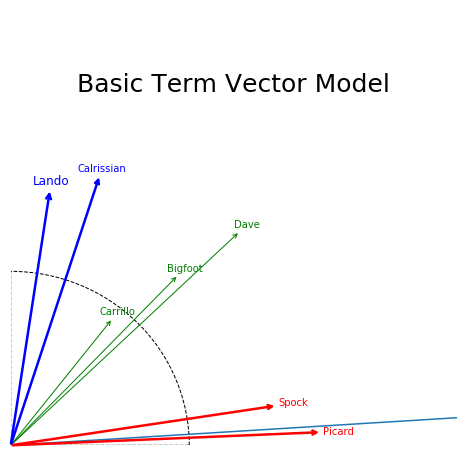

In [5]:
##### Import spline from scipy.interpolate.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import matplotlib.patches as patches
from matplotlib.path import Path
import pandas as pd

fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
theta1, theta2 = 0, 90
radius = .1
center = (0, 0)

# Main angle guide:
w1 = Wedge(center, radius, theta1, theta2, fill=False, linestyle='dashed')
w1.set_linewidth(1)
ax.add_artist(w1)

# Vector examples:
ax.annotate('Dave', (0, 0), (0.5, 0.5),
            arrowprops=dict(arrowstyle='<-', color="g"),
            xycoords='data', textcoords='axes fraction', color="g")

ax.annotate('Bigfoot', (0, 0), (0.35, 0.4),
            arrowprops=dict(arrowstyle='<-', color="g"),
            xycoords='data', textcoords='axes fraction', color="g")

ax.annotate('Carrillo', (0, 0), (0.2, 0.3),
            arrowprops=dict(arrowstyle='<-', color="g"),
            xycoords='data', textcoords='axes fraction', color="g")

ax.annotate('Calrissian', (0, 0), (0.15, 0.63),
            arrowprops=dict(arrowstyle='<-', color="b", linewidth=2.5),
            xycoords='data', textcoords='axes fraction', color="b")

ax.annotate('Lando', (0, 0), (0.05, 0.6),
            arrowprops=dict(arrowstyle='<-', color="b", linewidth=2.5),
            xycoords='data', textcoords='axes fraction', fontsize=12, color="b")

ax.annotate('Spock', (0, 0), (.6, 0.09),
            arrowprops=dict(arrowstyle='<-', color="r", linewidth=2.5),
            xycoords='data', textcoords='axes fraction', color="r")

ax.annotate('Picard', (0, 0), (.7, 0.025),
            arrowprops=dict(arrowstyle='<-', linewidth=2.5, color="r"),
            xycoords='data', textcoords='axes fraction', color="r")

# Remove splines on the top and right.
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim([0, .25])
ax.set_xlim([0, .25])
ax.set_xmargin(.001)
ax.set_ymargin(.001)
ax.set_autoscale_on(False)


x = np.linspace(0, 2*np.pi, 100)
plt.plot(x)
plt.title("Basic Term Vector Model", fontsize=25, position=(0.5, 0.8))
plt.ylabel("Star Wars", fontsize=18, color="b")
plt.xlabel("Star Track", fontsize=18, color="r")


plt.margins(0.005, 0.0001)

plt.show()

Each word in our corpus is related to either "Star Wars" or "Star Trek.” We'll use a vector space model to calculate the distance of each word to each topic.

> Topics generated from an LDA model are actually clusters of word probabilities without clearly defined labels. Simplifying word vectors like this should give you a sense of intuition about how **words vectors** relate to **topics**.

<a id='how-lda-works'></a>
## How LDA Works

---

_An abridged explanation:_

![](https://snag.gy/aiSFrm.jpg)

LDA isn't exactly straightforward when it comes to the math. But we can explore it piece by piece in more general terms.

In [6]:
yelp = pd.read_csv('./datasets/yelp.csv', encoding='utf-8')

In [10]:
# ! pip install textblob

In [11]:
from textblob import TextBlob

In [12]:
from sklearn.feature_extraction import stop_words
stopwords = stop_words.ENGLISH_STOP_WORDS

In [13]:
good = [list(TextBlob(x.lower()).words) for x in yelp[yelp.stars==5].text.values[0:25]]
bad = [list(TextBlob(x.lower()).words) for x in yelp[yelp.stars==1].text.values[0:25]]

In [14]:
good = [[w for w in doc if w not in stopwords] for doc in good]
bad = [[w for w in doc if w not in stopwords] for doc in bad]
good[11]

['time',
 'friend',
 'went',
 'delicious',
 'food',
 'garlic',
 'knots',
 'favorite',
 'course',
 'wine',
 'going',
 'alot']

<a id='step1'></a>
### Step 1: Choose `k` topics.

This is similar to the KNN algorithm. By setting `k`, we are deciding on a preset number of topics to determine.

In [204]:
# A:

<a id='step2'></a>
### Step 2: Randomly assign words in documents to topics.

First, let's denote the symbols for the different components:

- $D$ represents the documents; $d$ is a document.

- $W$ represents all the words in the documents; $w$ is a word.

- $Z$ represents the collection of our $k$ topics; $z$ is one of those topics.

We'll start off with a completely random assignment of words to topics. Iterate through the documents ($D$), and, for each word ($W$) in each document, randomly assign the word to be in one of the $Z$ topics.

In [205]:
# A:

50 2676


<a id='step3'></a>
### Step 3: Word distributions of topics.

Now that we've randomly assigned words to topics, we have the word distributions of different topics. These distributions indicate the probability of a word being in a topic. We can write out the probability of a word being selected, given a choice of one of our topics, like so:

### $$ P(\text{word } w \;|\; \text{topic } z) $$

We also have the probability of *topic* occurrence given a specific document, which is the proportion of words in a document that are assigned to a particular topic:

### $$ P(\text{topic } z \;|\; \text{document } d) $$


In [210]:
# p(z|d): The proportion of words in document d assigned to topic z.


In [211]:
# p(w|z): The proportion of words in topic z that are this word.

<a id='step4'></a>
### Step 4: Reassignment of topics.

Now we'll go through an iterative procedure. We’ll walk through the words in the documents repeatedly and calculate which topic a word should be reassigned to at each step.

First, we need to calculate the probability associated with each topic:

### $$ P(\text{topic } z \;|\; \text{document } d) \cdot P(\text{word } w \;|\; \text{topic } z) $$

This is the probability that the topic generated our current word. Below, we can calculate the probability of a word in the first document being generated from each of our topics.

In [ ]:
# A:

We can write a function that will sample from the topics according to these probabilities to assign a new topic.

In [ ]:
# A:

To put it all together, we can write a function that will iterate over all of the words/documents a specified number of times and complete the reassignment.

In [ ]:
# A:

<a id='step5'></a>
### Step 5: Getting words that define topics and topics that define documents.

To get the topic distribution for a document, we can use the function that calculated the probability of a topic given a previous document.

In [ ]:
# A:

Let's check this out for the first three documents.

In [ ]:
# A:

We can calculate the words that have greatest probability of occurring for a given topic to get the words that define topics.

In [ ]:
# A:

<a id='caveat'></a>
### A Major Caveat: Oversimplification

This is an oversimplified version of LDA. We've completely ignored priors and didn't talk about the Dirichlet distribution at all. That being said, this is the general breakdown of what’s happening. We perform a procedure in which we assign words to topics based on how likely it is that a topic would have generated that word. 

> **Note:** More legitimate implementations of LDA have hyperparameters such as alpha. Alpha is a scalar that helps minimize an error term. Thankfully, most implemented LDA models will set this automatically, and the solution is usually fine 95 percent of the time. There are white papers you can read to get a strong handle on the math behind this model. Additionally, having a solid understanding of Bayesian statistics is a must to really grasp this model at its lowest levels — but we won't get into that today.

<a id='lda-intuition'></a>
## LDA Intuition

---
 
As we iterate through each word in our corpus and (re)assign them to a topic:

1) Words will become more common in topics where they’re already common.
2) Topics will become more common in documents where they’re already common.

**Remember:**:

- Words are assigned to topics randomly at first.
- As words are found to be consistently distributed within topics, the model achieves a sort of equilibrium based on the distribution of words across all documents.

<a id='lda-challenges'></a>
## LDA's Challenges

---

1) **There's a bit of entropy to topics.**
There can be between a one- and 10-percent shift in what's generated in LDA models. You may not get the same result twice.

2) **It can be very difficult to assess.**
If you have a large corpus with many topics (>10), it's almost impossible to visualize the distribution of documents to topics.

3) **Preprocessing is heavy.**
Cleaning stop words and specific language can be a challenging task to get the most out of LDA. Sometimes it's difficult to avoid the noise involved with this model.

4) **Subject matter expertise is necessary for accurate topic assessment.**
The more straightforward your text is, the less subject matter expertise is required. A more advanced use of LDA would involve assessing documents with lots of idiomatic language. Knowing what topics are found can be subjective.

5)  **Determining what topics mean is tricky.**
A collection of word probabilities generally isn't very intuitive. You could take the first word and use that as your topic "label." Therefore, more subject matter expertise is required.

6) **LDA is unsupervised.**
It's impossible to know what’s correct. The response topics are generated, so LDA is known as a generative model. 

7) **Tuning your LDA model can be tough."**
It's possible to tune for the parameter **k** *number of topics*, but it's not necessarily a very straightforward way to improve your model.

<a id='lda-strengths'></a>
## LDA's Strengths

---

1) **It can be very strong performer in production.**
After you build the model, it can be easily used "online."
> "Online" training allows you to update your model with more training data without having to refit all of your data. Only new data can be fit globally.

2) **It's easy to get a quick sense of what a large body of text is broadly about without having to read all of it.** Rather than reading 12,000 PDFs on corporate policies, you could extract the text and run LDA to see what generalities it finds.

3) **It easily classifies and tags documents by topic.**

4) **It can "just work" out of the box.** However, your mileage will vary depending on your preprocessing.

<a id='other-models'></a>
## Models Similar to LDA

---

- Topics over time.
- Dynamic topic modeling.
- Hierarchical LDA
- Pachinko allocation. 

Additionally, a cool new LDA model to look out for is [LDA2Vec](http://multithreaded.stitchfix.com/blog/2016/05/27/lda2vec/).